<a href="https://colab.research.google.com/github/willowcoleman/hmc-senior-thesis/blob/main/PanColorGAN_opti_thermal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying PanColorGAN to thermal-optical patch-pairs

**Author: Red Willow Coleman**

Last modified: 4/23/2022

*Ozcelik, F., Alganci, U., Sertel, E., & Unal, G. (2020). Rethinking CNN-Based Pansharpening: Guided Colorization of Panchromatic Images via GANs. arXiv preprint arXiv:2006.16644.*

In [1]:
!git clone https://github.com/ozcelikfu/PanColorGAN.git
!cp PanColorGAN/*.py ./
!gdown --id 1F4iCyeC_5OXWada3UW780YgXx-63GQno --output PanColorGANRD.pth

Cloning into 'PanColorGAN'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 175 (delta 99), reused 155 (delta 85), pack-reused 0
Receiving objects: 100% (175/175), 8.53 MiB | 14.37 MiB/s, done.
Resolving deltas: 100% (99/99), done.
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1F4iCyeC_5OXWada3UW780YgXx-63GQno
To: /content/PanColorGANRD.pth
100% 32.7M/32.7M [00:00<00:00, 62.2MB/s]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from networks import define_G
from util import patch_sixteen, divide_sixteen, show_image, scale_range
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from zipfile import ZipFile
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter
!pip install sewar
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp
from statistics import mean
from scipy.stats import levene 
from pathlib import Path
import imghdr

# Allows  tensorflow code to work with torch 
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config 
np_config.enable_numpy_behavior()

%matplotlib inline

  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10608 sha256=47a2a96ab1945acb27d7dfb206e3b576d7f6e7fae3e2fbd2b553ccaadaa4fe97
  Stored in directory: /root/.cache/pip/wheels/7a/38/6b/d066cfcb2b1c1c9b059b9ce1bdc4803b469359214e8dad4e3e
Successfully built sewar


In [4]:
## Load in zipped training data sets 
train_zip = '/content/drive/MyDrive/Colab Notebooks/HMC Thesis/train_128_norm.zip'
test_zip = '/content/drive/MyDrive/Colab Notebooks/HMC Thesis/test_128_norm.zip'

# Extract all zipped files to /Retiled_128 dir in Drive
with ZipFile(train_zip, 'r') as zip_f:
  print('Extracting all TRAINING files now...')
  zip_f.extractall()
  print('Done!')

# Extract all zipped files to /Retiled_256 dir in Drive
with ZipFile(test_zip, 'r') as zip_f:
  print('Extracting all TESTING files now...')
  zip_f.extractall()
  print('Done!')
  

Extracting all TRAINING files now...
Done!
Extracting all TESTING files now...
Done!


## Check for and delete any corrupted training images ##


In [5]:
## TEST images ## 

data_dir = '/content/test_128_norm/' 
image_extensions = [".jpeg"] 
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
del_list = []

for filepath in Path(data_dir).rglob("*"):
  if filepath.suffix.lower() in image_extensions:
    img_type = imghdr.what(filepath)
    if img_type is None:
      print(f"{filepath} is not an image")
      del_list.append(str(filepath))
    elif img_type not in img_type_accepted_by_tf:
      print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
      del_list.append(str(filepath))

## Delete any files from del_list (not real images)
for del_file in del_list: 
  os.remove(del_file)
  print(os.path.basename(del_file), 'deleted')

## TRAIN images ## 
data_dir = '/content/train_128_norm/'
del_list = []

for filepath in Path(data_dir).rglob("*"):
  if filepath.suffix.lower() in image_extensions:
    img_type = imghdr.what(filepath)
    if img_type is None:
      print(f"{filepath} is not an image")
      del_list.append(str(filepath))
    elif img_type not in img_type_accepted_by_tf:
      print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
      del_list.append(str(filepath))

## Delete any files from del_list (not real images)
for del_file in del_list: 
  os.remove(del_file)
  print(os.path.basename(del_file), 'deleted')


/content/test_128_norm/._test_0_austin_fall_1_3.jpeg is not an image
._test_0_austin_fall_1_3.jpeg deleted
/content/train_128_norm/._train_0_austin_fall_1_1.jpeg is not an image
/content/train_128_norm/._train_0_chicago_spring_1_1.jpeg is not an image
._train_0_austin_fall_1_1.jpeg deleted
._train_0_chicago_spring_1_1.jpeg deleted


## Adapting PanColorGAN pre-trained weights model to work with opti-thermal patch-pairs

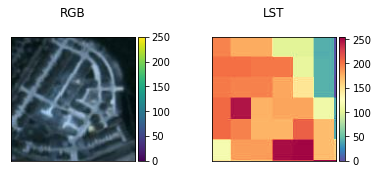

(128, 128, 4)
(128, 128)


In [6]:
## Data Display (RWC)

def load(image_file):

  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # (1) LST
  # (2) RGB
  w = tf.shape(image)[1]
  w = w // 2
  lst_img = image[:, w:, :]
  ms_img = image[:, :w, :]

  ms_img = np.stack((ms_img[:,:,0], ms_img[:,:,1], ms_img[:,:,2], ms_img[:,:,2])).T

  return ms_img, lst_img

def invisible_ax(ax):
    """
    Removes axes labels and tick marks for simple patch-pair visualizations
    """
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    return ax 

def plot_side_by_side(ms, lst, pan = None): 
  r = ms[:,:,0]
  g = ms[:,:,1]
  b = ms[:,:,2]
  rgb_img = np.stack((r,g,b)).T
  if pan is not None: 
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    ax1 = invisible_ax(ax1)
    ax2 = invisible_ax(ax2)
    ax3 = invisible_ax(ax3)
    im1 = ax1.imshow(rgb_img, cmap = 'Spectral_r')
    ax1.set_title('RGB', pad = 20)
    im2 = ax2.imshow(lst, cmap='Spectral_r')
    ax2.set_title('LST', pad = 20)
    im3 = ax3.imshow(pan, cmap='Spectral_r')
    ax3.set_title('Sharpened LST', pad = 20)

    # divider = make_axes_locatable(ax1)
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    # fig.colorbar(im1, cax=cax, orientation='vertical')

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical');

    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical');

    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=2, wspace=0.5, hspace=0.2)


  else: 
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1 = invisible_ax(ax1)
    ax2 = invisible_ax(ax2)
    im1 = ax1.imshow(rgb_img)
    ax1.set_title('RGB', pad = 20)
    im2 = ax2.imshow(lst[:,:,0], cmap='Spectral_r') 
    ax2.set_title('LST', pad = 20)

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical');

    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=2, wspace=0.5, hspace=0.2)

  plt.show()

ms, lst = load('/content/test_128_norm/test_0_austin_fall_2_4.jpeg')
plot_side_by_side(ms,lst)

lst = lst[:,:,0]

print(ms.shape)
print(lst.shape)

In [7]:
## Parameters
#@title Parameters { display-mode: "form" }
reduced_res=True #@param {type:"boolean"}
use_gpu=True #@param {type:"boolean"}

In [8]:
## Image normalization (RWC)

# Normalize images from [-1,1] by tile
def normalize_by_tile(ms_img, lst_img): 
  ms_min = tf.math.reduce_min(ms_img)
  ms_max = tf.math.reduce_max(ms_img)
  ms_img = (2*(ms_img - ms_min)/(ms_max - ms_min)) - 1 

  lst_min = tf.math.reduce_min(lst_img)
  lst_max = tf.math.reduce_max(lst_img)
  lst_img = (2*(lst_img - lst_min)/(lst_max - lst_min)) - 1 

  ms_img = tf.cast(ms_img, tf.float32)
  lst_img = tf.cast(lst_img, tf.float32)

  return ms_img, lst_img, ms_min, ms_max, lst_min, lst_max

# Denormalize images from [-1,1] to [0,255] 
def denormalize_by_tile(img_min, img_max, norm_img):
    return img_min + (0.5)*(img_max - img_min)*(norm_img + 1)

# Denormalize images from [0,255] to [Kelvin] using lst_min and lst_max values fromlst_lookup.csv
def lst_denormalization(lst_min, lst_max, lst_norm):
    lst = lst_min + (lst_norm * (lst_max - lst_min))/255
    return lst


In [9]:
## Network Preparation
model_weights = "/content/PanColorGANRD.pth"
netG = define_G(5, 4, 32, 'batch','leakyrelu', False, 'ResizeConv', 'colorunet', 'SE', 6, [0], n_downsampling=2)
#netG.load_state_dict(torch.load(model_weights, map_location=lambda storage, loc: storage))
netG.load_state_dict(torch.load(model_weights))
netG.eval()

if use_gpu:
  netG = netG.cuda()
else:
  netG = netG.cpu()

In [10]:
def pansharpen(ms_norm, lst_norm, netG, use_gpu, reduced_res): 
  if reduced_res:
    ms_down = [resize(i,(64,64), 3) for i in ms_norm]
    ms_up = [resize(i, (256, 256), 3) for i in ms_down]
    ms_norm = np.clip(ms_up,-1.0,1.0)
    lst_down = resize(lst_norm, (256, 256), 3)
    lst_norm = np.clip(lst_down,-1.0,1.0)
  else: 
    ms_up = [resize(i, (1024, 1024), 3) for i in ms_norm]
    ms_norm = np.clip(ms_up,-1.0,1.0)

  inp = np.concatenate((ms_norm,np.expand_dims(lst_norm,axis=0)),axis=0)
  if not reduced_res:
    inp = divide_sixteen(inp)
  inp = torch.tensor(inp)

  if use_gpu:
    out = netG(inp.cuda().view(-1,5,256,256)).detach().cpu().numpy()
  else:
    out = netG(inp.view(-1,5,256,256)).detach().numpy()

  if not reduced_res:
    out = patch_sixteen(out)

  return out


### Comparing MS and LST values within a single ECOSTRESS pixel

In [11]:
"""
Given the unique indices that we have now saved in ind_dict, it will be possible
to compare the variances in ms and avg_gaussian

1. Iterate through all 70 m LST pixels one-by-one
2. Subset MS 3 m pixels from that unique LST pixel
3. Subset avg_gaussian ~3 m pixels from that unique LST pixel 
4. Compare variances between MS and avg_gaussian

Variance calculated using Levene's test because the distributions are not 
necessarily normal
"""

def variance_signficance(ind_dict, ms_flat, gaussian_denorm_flat, f, plot = False):
  ms_var = [] # store variance of RGB imagery 
  gaussian_var = [] # store variance of avg_gaussian

  # Iterate through unique LST values
  for key in ind_dict: 
    temp_ms = []
    temp_gaussian = []
    inds = ind_dict[key]
    # Iterate through indices with a unique LST value
    for ind in inds: 
      temp_ms.append(ms_flat[ind])
      temp_gaussian.append(gaussian_denorm_flat[ind])
    ms_var.append(np.var(temp_ms))
    gaussian_var.append(np.var(temp_gaussian))

  # Plot distribution of variance of MS and sharpened LST imagery from the same patch-pair
  if plot == True: 
    plt.hist(ms_var, bins = 10, edgecolor = 'black', color = '#43751e')
    plt.title("Variance of MS image: " + str(f))
    plt.xlabel('Normalized RGB')
    plt.ylabel('Frequency')
    plt.show()

    plt.hist(gaussian_var, bins = 10, edgecolor = 'black', color = '#035a6e')
    plt.title("Variance of Pansharpened Gaussian-Smoothed LST: " + str(f))
    plt.xlabel('Normalized LST')
    plt.ylabel('Frequency')
    plt.show()

  # If p < 0.05, the populations do not have equal variances 
  stat, p = levene(ms_var, gaussian_var)

  return p

""" 
Determine what the average value of the pansharpened, gaussian-smoothed LST is 
within each 70 m ECOSTRESS pixel and return this as a numpy array
"""

def calculate_average_of_pixel(ind_dict, gaussian_denorm_flat):
  # Iterate through unique LST values
  avg_flat = np.zeros(128*128)
  for key in ind_dict: 
    inds = ind_dict[key]
    avg_list = []
    # Iterate through indices with a unique LST value
    for ind in inds: 
      avg_list.append(gaussian_denorm_flat[ind])
    avg_flat[inds] = mean(avg_list)

  # Reshape flattened array 
  avg_gaussian_denorm = avg_flat.reshape(128,128)

  return avg_gaussian_denorm


## Apply pre-trained PanColorGAN model

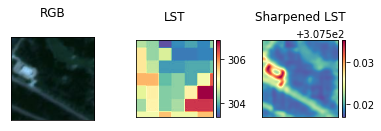

% of patch-pairs with statistically different variances: 100.0


In [14]:
# Load in lookup table to denormalize from 0-255 back to Kelvin
fpath = '/content/drive/MyDrive/Colab Notebooks/HMC Thesis/lst_lookup.csv'
lst_lookup = pd.read_csv(fpath)

# Empty lists for image quality metrics 
rmse_spatial_list = []
rmse_spectral_list = []
ergas_spatial_list = []
ergas_spectral_list = []
sam_list = []

p_list = [] # Keep track if difference in variances is signficant

plot = True

# Iterate through training images 
for f in os.listdir('/content/train_128_norm/')[400:401]:
  # Load in training image
  # print('File name:', f)
  ms, lst = load(os.path.join('/content/train_128_norm', f))
  lst = lst[:,:,0] # Reshape

  # Normalize iamges from [-1,1]
  ms_norm, lst_norm, ms_min, ms_max, lst_min, lst_max = normalize_by_tile(ms, lst)
  ms_norm = ms_norm.T 

  # Apply pre-trained pansharpening network 
  pan = pansharpen(ms_norm, lst_norm, netG, use_gpu, reduced_res)

  # Apply Gaussian blurring to get rid of quilting edge effects
  gaussian = gaussian_filter(pan[0,0,:,:], sigma = 5)
  gaussian = resize(gaussian, (128,128),3)
  pan = resize(pan[0,0,:,:], (128,128), 3)

  # Calculate image quality metrics (normalized images)
  if gaussian.shape == lst.shape: # Some images are weirdly shaped? 
    rmse_spectral_list.append(rmse(gaussian, lst_norm))
    rmse_spatial_list.append(rmse(gaussian, ms_norm[0,:,:]))
    ergas_spectral_list.append(ergas(gaussian, lst_norm))
    ergas_spatial_list.append(ergas(gaussian, ms_norm[0,:,:]))
    sam_list.append(sam(gaussian, lst_norm))

  # Get LST denormalization values from lst_lookup.csv (pre-created during image export)
  f_short = f[6:len(f)-5] # Key in lst_lookup, 5:len if test, 6:len if train
  lst_min = lst_lookup[f_short][0]
  lst_max = lst_lookup[f_short][1] 
  
  # Denormalize LST images ([-1,1] -> [0,255] -> [Kelvin])
  pan_denorm_0 = denormalize_by_tile(lst_min, lst_max, pan)
  pan_denorm = lst_denormalization(lst_min, lst_max, pan_denorm_0)
  gaussian_denorm_0 = denormalize_by_tile(lst_min, lst_max, gaussian)
  gaussian_denorm = lst_denormalization(lst_min, lst_max, gaussian_denorm_0)
  lst_denorm = lst_denormalization(lst_min, lst_max, lst).numpy()

  # Compare MS and LST values within a single ECOSTRESS pixel 
  lst_denorm = np.around(lst_denorm, 2)

  # Flatten arrays 
  lst_denorm_flat = lst_denorm.flatten()
  gaussian_denorm_flat = gaussian_denorm.flatten()
  ms_norm_flat = ms_norm.numpy().flatten() # [-1,1]
  gaussian_norm_flat = gaussian.flatten() # [-1,1]
  pan_denorm_flat = pan_denorm.flatten()

  # Save unique LST values and indices in dictionary
  ind_dict = {i:np.where(lst_denorm_flat == i)[0] for i in set(lst_denorm_flat)}

  # Determine if variance between MS and sharpened within an ECOSTRESS pixel is significant
  p = variance_signficance(ind_dict, ms_norm_flat, gaussian_norm_flat, f_short, plot = False)
  p_list.append(p)

  if plot == True: 
    avg_gaussian_denorm = calculate_average_of_pixel(ind_dict, gaussian_denorm_flat)
    plot_side_by_side(ms, lst_denorm, gaussian_denorm)
    # plot_side_by_side(ms, lst_denorm, pan_denorm)

# Get percentage of variances that are statistically significant (p < 0.05)
sig_frac = (len([ele for ele in p_list if ele < 0.05]) / len(p_list)) * 100
print('% of patch-pairs with statistically different variances:', sig_frac)

In [ ]:
# Load in lookup table to denormalize from 0-255 back to Kelvin
fpath = '/content/drive/MyDrive/Colab Notebooks/HMC Thesis/lst_lookup.csv'
lst_lookup = pd.read_csv(fpath)

# Determine which sigma value is best by keeping track of if difference in variances is significant
sigma_0 = []
sigma_2 = []
sigma_4 = []
sigma_6 = []
sigma_8 = []
sigma_10 = []

plot = False

# Iterate through training images 
for f in os.listdir('/content/test_128_norm/')[0:2000]:
  # Load in training image
  # print('File name:', f)
  ms, lst = load(os.path.join('/content/test_128_norm', f))
  lst = lst[:,:,0] # Reshape

  # Normalize iamges from [-1,1]
  ms_norm, lst_norm, ms_min, ms_max, lst_min, lst_max = normalize_by_tile(ms, lst)
  ms_norm = ms_norm.T 

  # Apply pre-trained pansharpening network 
  pan = pansharpen(ms_norm, lst_norm, netG, use_gpu, reduced_res)

  # Apply Gaussian blurring to get rid of quilting edge effects
  gaussian_2 = gaussian_filter(pan[0,0,:,:], sigma = 2)
  gaussian_2 = resize(gaussian_2, (128,128),3).flatten()

  gaussian_4 = gaussian_filter(pan[0,0,:,:], sigma = 4)
  gaussian_4 = resize(gaussian_2, (128,128),3).flatten()

  gaussian_6 = gaussian_filter(pan[0,0,:,:], sigma = 6)
  gaussian_6 = resize(gaussian_2, (128,128),3).flatten()

  gaussian_8 = gaussian_filter(pan[0,0,:,:], sigma = 8)
  gaussian_8 = resize(gaussian_2, (128,128),3).flatten()

  gaussian_10 = gaussian_filter(pan[0,0,:,:], sigma = 10)
  gaussian_10 = resize(gaussian_2, (128,128),3).flatten()

  # Get LST denormalization values from lst_lookup.csv (pre-created during image export)
  f_short = f[5:len(f)-5] # Key in lst_lookup, 5:len if test, 6:len if train
  lst_min = lst_lookup[f_short][0]
  lst_max = lst_lookup[f_short][1] 
  
  # Denormalize LST images ([-1,1] -> [0,255] -> [Kelvin])
  lst_denorm = lst_denormalization(lst_min, lst_max, lst).numpy()
  lst_denorm = np.around(lst_denorm, 2).flatten()

  # Save unique LST values and indices in dictionary
  ind_dict = {i:np.where(lst_denorm == i)[0] for i in set(lst_denorm)}

  # Determine if variance between MS and sharpened within an ECOSTRESS pixel is significant
  sigma_0.append(variance_signficance(ind_dict, ms_norm.numpy().flatten(), pan[0,0,:,:].flatten(), f_short, plot = False))
  sigma_2.append(variance_signficance(ind_dict, ms_norm.numpy().flatten(), gaussian_2, f_short, plot = False))
  sigma_4.append(variance_signficance(ind_dict, ms_norm.numpy().flatten(), gaussian_4, f_short, plot = False))
  sigma_6.append(variance_signficance(ind_dict, ms_norm.numpy().flatten(), gaussian_6, f_short, plot = False))
  sigma_8.append(variance_signficance(ind_dict, ms_norm.numpy().flatten(), gaussian_8, f_short, plot = False))
  sigma_10.append(variance_signficance(ind_dict, ms_norm.numpy().flatten(), gaussian_10, f_short, plot = False))

# Get percentage of variances that are statistically significant (p < 0.05)
sig_frac_0 = (len([ele for ele in sigma_0 if ele < 0.05]) / len(sigma_0)) * 100
print('Sigma = 0, % of patch-pairs with statistically different variances:', sig_frac_0)
sig_frac_2 = (len([ele for ele in sigma_2 if ele < 0.05]) / len(sigma_2)) * 100
print('Sigma = 2, % of patch-pairs with statistically different variances:', sig_frac_2)
sig_frac_4 = (len([ele for ele in sigma_4 if ele < 0.05]) / len(sigma_2)) * 100
print('Sigma = 4, % of patch-pairs with statistically different variances:', sig_frac_4)
sig_frac_6 = (len([ele for ele in sigma_6 if ele < 0.05]) / len(sigma_2)) * 100
print('Sigma = 6, % of patch-pairs with statistically different variances:', sig_frac_6)
sig_frac_8 = (len([ele for ele in sigma_8 if ele < 0.05]) / len(sigma_2)) * 100
print('Sigma = 8, % of patch-pairs with statistically different variances:', sig_frac_8)
sig_frac_10 = (len([ele for ele in sigma_10 if ele < 0.05]) / len(sigma_2)) * 100
print('Sigma = 10, % of patch-pairs with statistically different variances:', sig_frac_10)


## Plotting Image Quality Metrics 

In [ ]:
# Summary statistics of image quality metrics 
N = len(p_list)
plt.hist(rmse_spectral_list, bins = 20, edgecolor = 'black', color = '#870f25')
plt.title(str(N) + ' PanColorGAN sharpened test images: RMSE (Spectral Distortion)')
plt.xlabel('RMSE (Spectral)')
plt.ylabel('Frequency')
plt.xlim(0,1.2)
plt.ylim(0,700)
plt.show()

plt.hist(rmse_spatial_list, bins = 20, edgecolor = 'black', color = '#870f25')
plt.title(str(N) + ' PanColorGAN sharpened test images: RMSE (Spatial Distortion)')
plt.xlabel('RMSE (Spatial)')
plt.ylabel('Frequency')
plt.xlim(0,1.2)
plt.ylim(0,700)
plt.show()

ergas_spectral_list_f = filter(lambda num: num < np.percentile(ergas_spectral_list, 95), ergas_spectral_list)

plt.hist(list(ergas_spectral_list_f), bins = 20, edgecolor = 'black', color = '#035a6e')
plt.title(str(N) + ' PanColorGAN sharpened test images: ERGAS (Spectral Quality)')
plt.xlabel('ERGAS (Spectral)')
plt.ylabel('Frequency')
plt.xlim(0,100000)
plt.ylim(0,500)
plt.show()

ergas_spatial_list_f = filter(lambda num: num < np.percentile(ergas_spatial_list, 95), ergas_spatial_list)

plt.hist(list(ergas_spatial_list_f), bins = 20, edgecolor = 'black', color = '#035a6e')
plt.title(str(N) + ' PanColorGAN sharpened test images: ERGAS (Spatial Quality)')
plt.xlabel('ERGAS (Spatial)')
plt.ylabel('Frequency')
plt.xlim(0,100000)
plt.ylim(0,500)
plt.show()

plt.hist(sam_list, bins = 20, edgecolor = 'black', color = '#43751e')
plt.title(str(N) + ' PanColorGAN sharpened test images: SAM (Spectral Distortion)')
plt.xlabel('SAM (Spectral)')
plt.ylabel('Frequency')
plt.xlim(0,2.5)
plt.ylim(0,1000)
plt.show()